# Data Analysis

Data analysis notebook for the results of the `DINCAE.jl` model training

In [571]:
import xarray
import numpy as np
import matplotlib.pyplot as plt

In [593]:
i = 3  # Index of the trial to analyze
base_folder = f"./results/trial_{i}/"

result = xarray.open_dataset(f"{base_folder}/data-avg.nc") # Model output

# subset = xarray.open_dataset(f"{base_folder}/dataset.nc") # Raw data
dataset = xarray.open_dataset(f"./data/dataset.nc") # Raw data
cleanup = xarray.open_dataset(f"{base_folder}/modis_cleanup.nc") # Cleaned data (pixels with quality flags > 3 or temperature > 40 removed)
cleanup_clouds = xarray.open_dataset(f"{base_folder}/modis_cleanup_add_clouds.nc") # Cleaned data with simulated clouds added

In [573]:
# Extracting the relevant data arrays

result_sst = result["sst"].values
# subset_sst = subset["sst"].values
cleanup_sst = cleanup["sst"].values
cleanup_clouds_sst = cleanup_clouds["sst"].values
sea_mask = cleanup_clouds["mask"].values.astype(bool) # 1 = water, 0 = land

N = result_sst.shape[0]

result_sst.shape, cleanup_sst.shape, cleanup_clouds_sst.shape, sea_mask.dtype, sea_mask.shape

((9006, 168, 144),
 (9006, 168, 144),
 (9006, 168, 144),
 dtype('bool'),
 (168, 144))

In [594]:
dataset_sorted = dataset.sortby('time')

In [574]:
def calculate_mean_image(dataset, n_days, index):
    reconstruction_days = [x for x in range(index - n_days, index + n_days + 1) if x != index]
    return np.nanmean(dataset[reconstruction_days], axis=0)

def reconstruct_image(output, original, cloud_mask):
    return np.where(cloud_mask, output, original)

def RMSE(reconstructed, original, cloud_mask):
    diff = (reconstructed - original)
    diff = diff[cloud_mask]
    return np.sqrt(np.nanmean(diff ** 2))

# RMSE_model = np.sqrt(np.nanmean((reconstructed_img - cleanup_sst[i]) ** 2))
# RMSE_mean = np.sqrt(np.nanmean((reconstructed_mean_img - cleanup_sst[i]) ** 2))


In [575]:
cloud_mask = sea_mask.reshape(-1, sea_mask.shape[0], sea_mask.shape[1]).repeat(cleanup_clouds_sst.shape[0], axis=0) &np.isnan(cleanup_clouds_sst) & ~np.isnan(cleanup_sst)

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_imgs = reconstruct_image(result_sst, cleanup_sst, cloud_mask)

## Calculate mean RMSE

Calculate the mean RMSE of the dataset, using:
- The output of the model
- The mean of the previous and following days

In [576]:
time_window = 7 # Specify the time window for reconstruction
n_days = time_window // 2 # Get the number of days before and after the current day

RMSE_rec = []
RMSE_mean = []
index = []

for i in range(n_days, N - n_days + 1):
   
    if not cloud_mask[i].any(): # If no clouds were applied, skip this iteration
        continue

    rec = RMSE(result_sst[i], cleanup_sst[i], cloud_mask[i])

    mean_res = calculate_mean_image(cleanup_clouds_sst, n_days, i)

    mn = RMSE(mean_res, cleanup_sst[i], cloud_mask[i])

    if np.isnan(mn) or np.isnan(rec):
        continue

    RMSE_rec.append(rec)
    RMSE_mean.append(mn)
    index.append(i)

print("Number of valid RMSE values:", len(RMSE_rec))
print("Mean RMSE Reconstruction:", np.mean(RMSE_rec))
print("Mean RMSE Mean:", np.mean(RMSE_mean))

/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_80389/3747278150.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(dataset[reconstruction_days], axis=0)


Number of valid RMSE values: 909
Mean RMSE Reconstruction: 3.4735653
Mean RMSE Mean: 0.9543307


In [577]:
sum(np.isnan(RMSE_rec)), sum(np.isnan(RMSE_mean))

(np.int64(0), np.int64(0))

In [578]:
# Sort indices by RMSE
RMSE_vals = np.stack((index, RMSE_rec), axis=1)
RMSE_vals = RMSE_vals[np.argsort(RMSE_vals[:, 1])]
RMSE_vals[0, 1], RMSE_vals[-1, 1]

(np.float64(0.7059527635574341), np.float64(8.846403121948242))

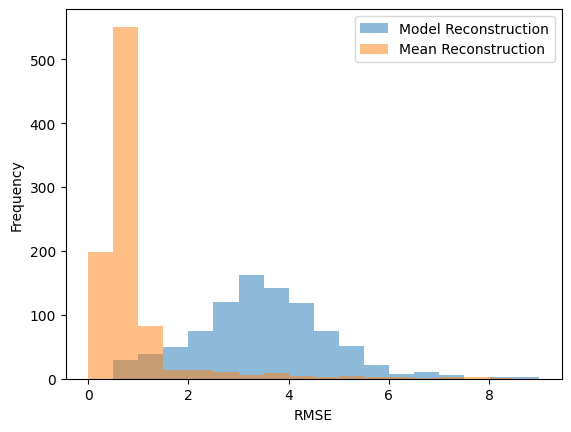

In [590]:
maxval = 9
plt.hist(RMSE_rec, bins=2 * maxval, alpha=0.5, label='Model Reconstruction', range=(0, maxval))
plt.hist(RMSE_mean, bins=2 * maxval, alpha=0.5, label='Mean Reconstruction', range=(0, maxval))
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

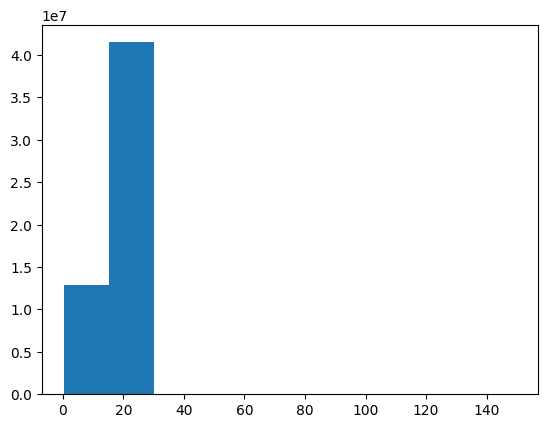

Max reconstructed value:  149.4292
Min reconstructed value:  0.47


In [580]:
# plt.hist(cleanup_sst.flatten(), bins=10, alpha=0.5)
plt.hist(reconstructed_imgs.flatten(), bins=10)
plt.show()
print("Max reconstructed value: ", np.nanmax(reconstructed_imgs))
print("Min reconstructed value: ", np.nanmin(reconstructed_imgs))

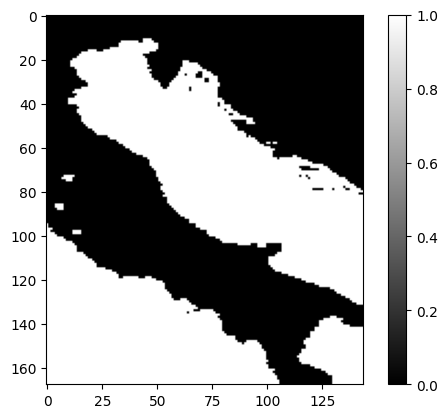

In [581]:
plt.imshow(sea_mask, cmap='gray')
plt.colorbar()

Index is:  7781
RMSE:
 Model: 8.846403121948242
 Mean: 12.557853698730469
RMSE:
 Model: 8.846403121948242


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_80389/3747278150.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(dataset[reconstruction_days], axis=0)


Min: 0.4699999988079071, Max: 33.48500061035156


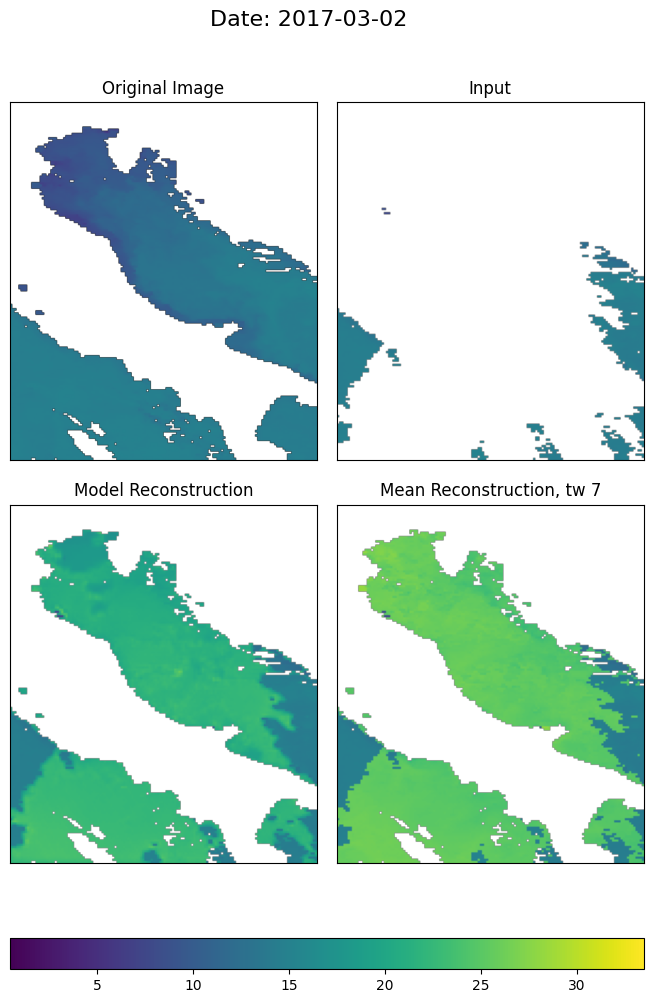

In [591]:

i = np.random.choice(RMSE_vals[:, 0].astype(int)) # Choose a random index from the sorted RMSE values
j = -1
i = RMSE_vals[j, 0].astype(int)  # Choose the index based on the RMSE
val = RMSE_vals[j, 1]
print("Index is: ", i)

date = cleanup.time[i].values.astype('datetime64[D]')

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_img = reconstruct_image(result_sst[i], cleanup_sst[i], cloud_mask[i])

# Calculate the mean of the surrounding days
mean_res = calculate_mean_image(cleanup_clouds_sst, n_days, i)

# Calculate the reconstructed image using the mean of the surrounding days where clouds were added
reconstructed_mean_img = reconstruct_image(mean_res, cleanup_sst[i], cloud_mask[i])

RMSE_model = RMSE(reconstructed_img, cleanup_sst[i], cloud_mask[i])
RMSE_m = RMSE(reconstructed_mean_img, cleanup_sst[i], cloud_mask[i])

# # Calculate RMSE between the reconstructed and original images
# RMSE_model = np.sqrt(np.nanmean((reconstructed_img - cleanup_sst[i]) ** 2))
# RMSE_mean = np.sqrt(np.nanmean((reconstructed_mean_img - cleanup_sst[i]) ** 2))

print(f"RMSE:\n Model: {RMSE_model}\n Mean: {RMSE_m}")
print(f"RMSE:\n Model: {val}")

# Calculate the min and max values for consistent color scaling
vmin = np.min([np.nanmin(reconstructed_img), np.nanmin(cleanup_clouds_sst), np.nanmin(reconstructed_mean_img)])
vmax = np.max([np.nanmax(reconstructed_img), np.nanmax(cleanup_clouds_sst), np.nanmax(reconstructed_mean_img)])
print(f"Min: {vmin}, Max: {vmax}")

fig, axs = plt.subplots(2, 2, figsize = (7, 10), sharex=True, sharey=True)
# fig.suptitle(f"RMSE Model: {RMSE_model:.2f}, RMSE Mean: {RMSE_mean:.2f}", fontsize=16)
fig.suptitle(f"Date: {date}", fontsize=16)

axs[0, 0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(cleanup_clouds_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Input')

axs[1, 0].imshow(reconstructed_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Model Reconstruction')

axs[1, 1].imshow(reconstructed_mean_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 1].set_title(f'Mean Reconstruction, tw {time_window}')

plt.tight_layout()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
cbar = plt.colorbar(axs[0, 0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax),
                    ax=axs,
                    orientation='horizontal',
                    fraction=0.04, pad=0.08)
plt.show()

Index is:  7734
RMSE:
 Model: 7.050542831420898
 Mean: 16.075199127197266
RMSE:
 Model: 7.050542831420898
Min: 0.4699999988079071, Max: 48.26093673706055


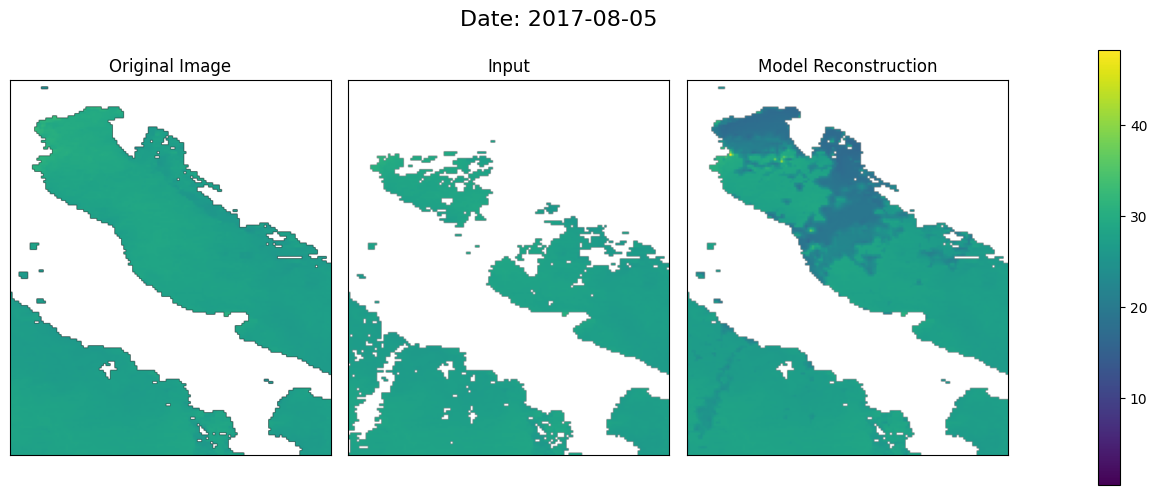

In [583]:
i = np.random.choice(RMSE_vals[:, 0].astype(int)) # Choose a random index from the sorted RMSE values
j = -10
i = RMSE_vals[j, 0].astype(int)  # Choose the index based on the RMSE
val = RMSE_vals[j, 1]
print("Index is: ", i)

date = cleanup.time[i].values.astype('datetime64[D]')

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_img = reconstruct_image(result_sst[i], cleanup_sst[i], cloud_mask[i])

# Calculate the reconstructed image using the mean of the surrounding days where clouds were added
reconstructed_mean_img = reconstruct_image(mean_res, cleanup_sst[i], cloud_mask[i])

RMSE_model = RMSE(reconstructed_img, cleanup_sst[i], cloud_mask[i])
RMSE_m = RMSE(reconstructed_mean_img, cleanup_sst[i], cloud_mask[i])

# # Calculate RMSE between the reconstructed and original images
# RMSE_model = np.sqrt(np.nanmean((reconstructed_img - cleanup_sst[i]) ** 2))
# RMSE_mean = np.sqrt(np.nanmean((reconstructed_mean_img - cleanup_sst[i]) ** 2))

print(f"RMSE:\n Model: {RMSE_model}\n Mean: {RMSE_m}")
print(f"RMSE:\n Model: {val}")

# Calculate the min and max values for consistent color scaling
vmin = np.min([np.nanmin(reconstructed_img), np.nanmin(cleanup_clouds_sst), np.nanmin(reconstructed_mean_img)])
vmax = np.max([np.nanmax(reconstructed_img), np.nanmax(cleanup_clouds_sst), np.nanmax(reconstructed_mean_img)])
print(f"Min: {vmin}, Max: {vmax}")

fig, axs = plt.subplots(1, 3, figsize = (12, 5), sharex=True, sharey=True)
# fig.suptitle(f"RMSE Model: {RMSE_model:.2f}, RMSE Mean: {RMSE_mean:.2f}", fontsize=16)
fig.suptitle(f"Date: {date}", fontsize=16)

axs[0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Original Image')

axs[1].imshow(cleanup_clouds_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('Input')

axs[2].imshow(reconstructed_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].set_title('Model Reconstruction')

plt.tight_layout()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
cbar = plt.colorbar(axs[0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax),
                    ax=axs,
                    orientation='vertical',
                    fraction=0.04, pad=0.08)
plt.show()

## Plot the loss

In [584]:
with open(base_folder + 'loss.txt', 'r') as f:
    loss = f.read()
    
loss = loss.split('\n')

loss = [float(x) for x in loss if x]  # Convert to float and remove empty strings

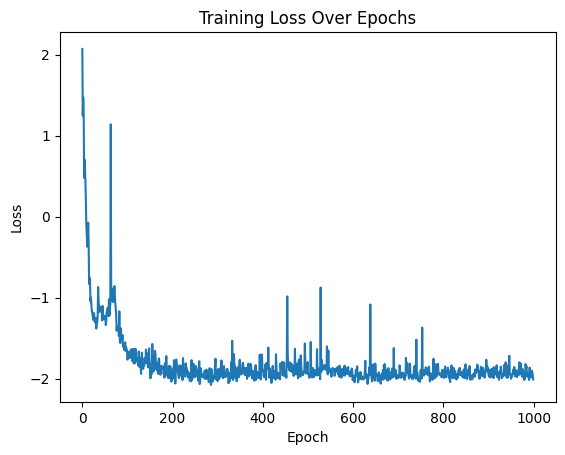

In [585]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [586]:
np.argmin(loss), loss[np.argmin(loss)], loss[-1]

(np.int64(285), -2.076725643543742, -2.0096681288940026)

In [587]:
np.argmax(loss)

np.int64(0)

In [588]:
loss[400], loss[500], loss[600], loss[700], loss[-1]

(-1.897458128897844,
 -1.9457924489104999,
 -1.9784002608490912,
 -1.9940742801129432,
 -2.0096681288940026)

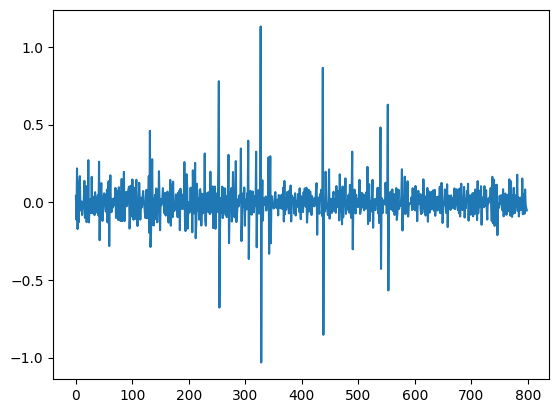

In [589]:
diff = [loss[i + 1] - loss[i] for i in range(len(loss) - 1)]
plt.plot(diff[200:])
